# Solventa el problema de la generación de la frontera para 30 activos.


In [2]:
import pandas as pd
import numpy as np
from time import time
from timeit import timeit
import matplotlib.pyplot as plt

In [12]:
window_width=30
dias = 261
n_empresas = 5
num_simulaciones = 50000

In [13]:
tiempo_inicial = time()

# Cargamos los datos y extraemos  los activos
datos = pd.read_csv('DAX.csv',sep=';')# Cargamos los dato
datos = datos.drop(['BUND'], 1) # Extraemos los activos quitando la última columnasy
datos = datos.iloc[(datos.shape[0]-261):datos.shape[0],:] # Extraemos los datos de un único año.A diferencia de R, en Python no es necesario reordenarlos
datos.index = datos.Fecha
activos = datos.drop(['Fecha'],1)# Extraemos los activos quitando la primera columna.

# Calculamos la rentabilidad de los activos.
rent_activos=pd.DataFrame(np.zeros((activos.shape[0] , activos.shape[1])), index=activos.index, columns=activos.columns) #  Generamos las matrices de datos donde guardaremos los resultados.
rent_activos = np.log(activos).diff()
rent_activos = rent_activos.iloc[1:rent_activos.shape[0],:]

# Necesitamos un criterio de preselección de activos. Por ejemplo: rentabilidad / riesgo (varianza)
rentabilidad_ponderada_riesgo = np.log(activos.iloc[0,0:activos.shape[1]]/activos.iloc[activos.shape[0]-1,0:activos.shape[1]])/rent_activos.var()
rentabilidad_ponderada_riesgo = rentabilidad_ponderada_riesgo.sort_values(ascending=True) # Se cogen los negativos en la medida que el ratio de rentabilidad se ha puesto en el numeroador el dato antigo

# Nos quedamos con los N activos que tengan mejor relación rentabilidad riesgo
rent_activos = rent_activos.loc[:,rentabilidad_ponderada_riesgo.index[0:n_empresas]]
activos = activos.loc[:,rentabilidad_ponderada_riesgo.index[0:n_empresas]]

# Calculamos la matriz de correlaciones
matriz_correlaciones = rent_activos.corr()

# Calculamos la matriz de varianzas / covarianzas.
matriz_var_covarianzas = rent_activos.cov() # Obtenemos diréctamente la matriz de varianzas covarianzas

# Calculamos la rentabilidad diaria del periodo para cada activo: LN(precio final/ precio inicial)/nº de datos
rent_diaria = pd.DataFrame(np.zeros((activos.shape[0],
                                     activos.shape[1])),
                                     index=activos.index, 
                                     columns=activos.columns)

rent_diaria = rent_diaria.head(1)
rent_diaria = rent_diaria.transpose()
activos = activos.transpose()
activos.iloc[:,activos.shape[1]-1]
activos.iloc[:,0]
rent_diaria = np.log(activos.iloc[:,activos.shape[1]-1]/activos.iloc[:,0])/dias
rent_diaria = rent_diaria.transpose()
activos = activos.transpose()
activos.shape[1]

# Sacamos la matriz de pesos para cada cartera
pesos = np.random.uniform(0,100,(num_simulaciones,activos.shape[1])) # pesos de todas simulaciones de una vez.
pesos = pd.DataFrame(pesos)
pesos = pesos.div(np.sum(pesos, axis=1), axis=0)
pesos = pesos.transpose()

# Calculamos la rentabilidad de la cartera en función de los pesos 
# Para cada conjunto de pesos queremos hacer suma producto de pesos con rentabilidad diaria.
    
matriz_intermedia = pd.DataFrame(np.zeros((pesos.shape[0] , pesos.shape[1])), index=pesos.index, columns=pesos.columns) 
rent_diaria.reset_index(inplace = True, drop = True)
matriz_intermedia_ones = pd.DataFrame(np.ones((pesos.shape[0] , pesos.shape[1])), index=pesos.index, columns=pesos.columns)
rent_diaria_matrix = matriz_intermedia_ones.mul(rent_diaria, axis=0)
matriz_intermedia = pesos.mul(rent_diaria_matrix, axis=0)
matriz_intermedia = matriz_intermedia.transpose() 
rentabilidad_carteras = matriz_intermedia.sum(axis=1) # Sumamos las filas para sacar rentabilidad de cada cartera.

# Calculamos el riesgo de la cartera (desviación), en función de los pesos.
# Multiplicamos la matriz de var/covar por cada fila de la matriz de pesos.
matriz_intermedia = np.dot(matriz_var_covarianzas,pesos)
matriz_intermedia = pd.DataFrame(matriz_intermedia).transpose()

# Multiplicamos cada fila de la matriz intermedia * cada fila de la matriz pesos y el rdo lo elevamos a 0.5. 
# Ojo, la multiplicación es matricial de dos vectores.
pesos = pesos.transpose() 
matriz_intermedia = pesos.mul(matriz_intermedia, axis=0)
riesgo_carteras = matriz_intermedia.sum(axis=1)
riesgo_carteras = riesgo_carteras**0.5

# Calculamos la eficiencia de la cartera (pendiente), en función de los pesos.
eficiencia_carteras = rentabilidad_carteras/riesgo_carteras
tiempo_final = time() 
tiempo_ejecucion = tiempo_final - tiempo_inicial

print ('El tiempo de ejecucion fue:',tiempo_ejecucion )

El tiempo de ejecucion fue: 0.047998666763305664


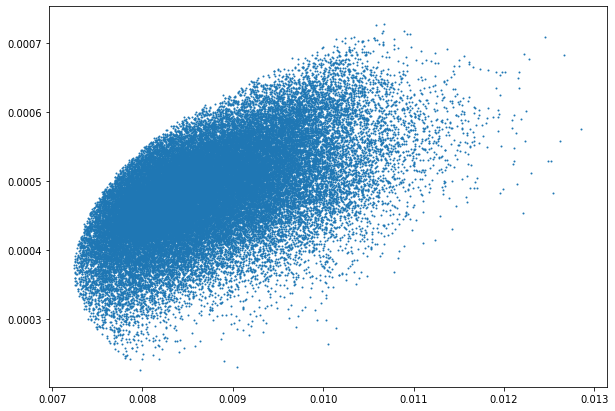

In [14]:
plt.figure(figsize=(10,7))
plt.plot(riesgo_carteras,rentabilidad_carteras,'o',markersize=1)
plt.show()

In [15]:
pesos.columns = rent_activos.columns 
pesos['rentabilidad_cartera'] = rentabilidad_carteras
pesos['riesgo_carteras'] = riesgo_carteras
pesos['eficiencia_cartera'] = eficiencia_carteras

In [16]:
max_rentabilidad = pesos[(pesos['rentabilidad_cartera'] == pesos.rentabilidad_cartera.max())==True]
min_riesgo = pesos[(pesos['riesgo_carteras'] == pesos.riesgo_carteras.min())==True]
max_eficiencia = pesos[(pesos['eficiencia_cartera'] == pesos.eficiencia_cartera.max())==True]

listametricas = ('max_rentabilidad','min_riesgo','max_eficiencia')
resumen = pd.concat([max_rentabilidad, min_riesgo, max_eficiencia])
resumen.reset_index(inplace = True, drop=True)
resumen['metrica'] = pd.DataFrame({'metrica':listametricas})
resumen

,FRESENIUS MED,MERCK,FRESENIUS,DEUTSCHE BANK,BEIERSDORF,rentabilidad_cartera,riesgo_carteras,eficiencia_cartera,metrica
0,0.470458,0.462913,0.061472,0.000118,0.005038,0.000728,0.010668,0.068241,max_rentabilidad
1,0.065099,0.199205,0.078224,0.476126,0.181345,0.000379,0.007245,0.052296,min_riesgo
2,0.365390,0.402114,0.002777,0.214511,0.015208,0.000624,0.008888,0.070262,max_eficiencia


## Otra manera de hacerlo

In [5]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline

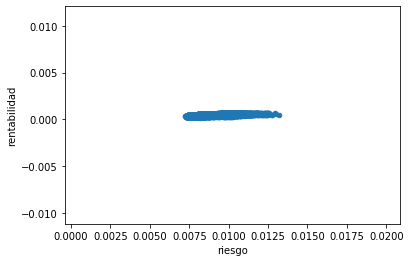

--- 0.48199939727783203 seconds ---


In [7]:
start_time = time.time()

n_empresas = 5
num_simulaciones = 50000
np.random.seed(42)

datos = pd.read_csv('DAX.csv', sep=';')
datos.set_index('Fecha', inplace=True)
datos = datos.iloc[len(datos)-260:] # filtramos un año
columns = datos.columns.tolist()
activos = datos[columns[:-2]]
rent_activos = np.log(activos).diff().dropna()
rentabilidad_ponderada_riesgo = (np.log(activos.iloc[-1]) - np.log(activos.iloc[0])) / rent_activos.var()

seleccion = list(rentabilidad_ponderada_riesgo.sort_values(ascending=False).iloc[:n_empresas].to_dict().keys())
rent_activos_filt = rent_activos[seleccion]
matriz_correlaciones = rent_activos_filt.corr()
matriz_covarianzas = rent_activos_filt.cov()

rent_diaria = (np.log(activos[seleccion].iloc[-1]) - np.log(activos[seleccion].iloc[0])) / len(activos)

rand_matrix = np.random.randint(0,100,(num_simulaciones,n_empresas))
pesos = pd.DataFrame(rand_matrix / rand_matrix.sum(axis=1)[:, np.newaxis], columns=seleccion)
rentabilidad_carteras = (pesos * rent_diaria).sum(axis=1)

matriz_intermedia = pesos.dot(matriz_covarianzas)
matriz_intermedia = matriz_intermedia * pesos
riesgo_carteras = matriz_intermedia.sum(axis=1) ** 0.5

eficiencia_carteras = rentabilidad_carteras / riesgo_carteras

pesos['rentabilidad'] = rentabilidad_carteras
pesos['riesgo'] = riesgo_carteras
pesos['eficiencia'] = eficiencia_carteras

max_rentabilidad = pesos['rentabilidad'].max()
min_riesgo = pesos['riesgo'].min()
max_eficiencia = pesos['eficiencia'].max()

pesos.plot.scatter(x='riesgo', y='rentabilidad')
plt.show()

print("--- %s seconds ---" % (time.time() - start_time))

## Otra manera de hacerlo

In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt

C:\Users\gmelendez\python-venv\venv-ml\lib\site-packages\ipykernel_launcher.py:55: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
C:\Users\gmelendez\python-venv\venv-ml\lib\site-packages\ipykernel_launcher.py:56: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
C:\Users\gmelendez\python-venv\venv-ml\lib\site-packages\ipykernel_launcher.py:57: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
m

--- 0.24702167510986328 seconds ---


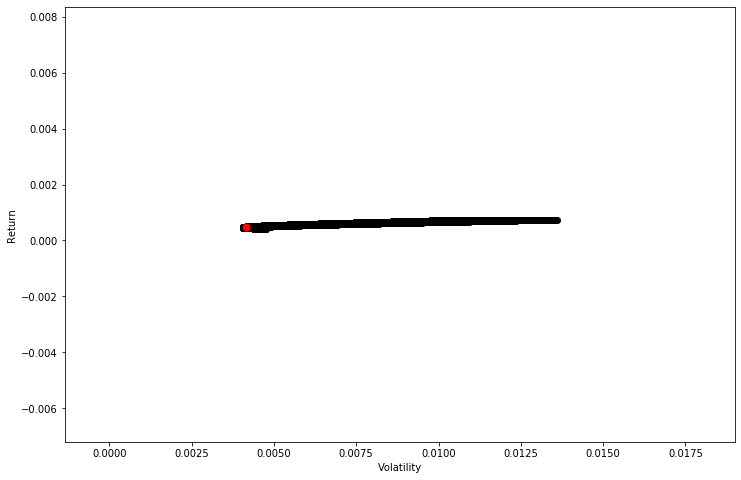

In [9]:
start_time = time.time()

filename = r'DAX.csv'
window = 10
data_to_select = 261
n_empresas = 3
num_simulations = 50000


pd_data = pd.read_csv(filename, header=0,
                      parse_dates=True, index_col=0, sep=';', dayfirst=True)
pd_data = pd_data.iloc[len(pd_data.index)-data_to_select:, :]
pd_data_log_ret = np.log(pd_data).diff()
pd_data_log_ret = pd_data_log_ret.iloc[1:, ]


risk_weighted_ret = np.log(
    pd_data.iloc[-1, :]/pd_data.iloc[0, :])/pd_data_log_ret.var()
top_n_index = risk_weighted_ret.sort_values(ascending=False)[:n_empresas].index


pd_data_log_ret_filtered = pd_data_log_ret.loc[:, top_n_index]
pd_data_filtered = pd_data.loc[:, top_n_index]

# Calculamos la matriz de correlaciones
corr_matrix = pd_data_log_ret_filtered.corr()

# Calculamos la matriz de covarianzas
cov_matrix = pd_data_log_ret_filtered.cov()

# Rentabilidad diaria
daily_return = pd.DataFrame(np.log(pd_data_filtered.iloc[-1, :] /
                                   pd_data_filtered.iloc[0, :])/
                            len(pd_data_filtered.index)).T


# Calculamos los pesos y los normalizamos
weights = pd.DataFrame(np.random.uniform(np.random.uniform(
    0.0, 100, size=(num_simulations, n_empresas))))
weights_norm = weights.div(weights.sum(axis=1), axis=0)

# Calculamos la rentabilidad de la cartera en función de los pesos
weights_norm.columns = daily_return.columns
temp_profit = daily_return @ weights_norm.T
portfolio_profit = temp_profit.T.sum(axis=1)

# Calculamos el riesgo de la cartera (desviación), en función de los pesos.
portfolio_risk = (weights_norm @ cov_matrix).mul(
    weights_norm, axis='index').sum(axis=1)**.5

# Calculamos la eficiencia de la cartera (pendiente), en función de los pesos.
portfolio_efficiency = portfolio_profit.divide(portfolio_risk)

# Localizamos la cartera con mayor rentabilidad, menor riesgo y mayor eficiencia.
best_portfolio = portfolio_efficiency.argmax()
min_risk = portfolio_risk.argmin()
max_profit = portfolio_profit.argmax()

# Graficamos la frontera de Markowitz (riesgo y rentabilidad para cada vector de pesos)
plt.figure(figsize=(12, 8))
plt.scatter(portfolio_risk, portfolio_profit, c='black')
plt.scatter(portfolio_risk[best_portfolio],
            portfolio_profit[best_portfolio], c='red', s=50) 
plt.xlabel('Volatility')
plt.ylabel('Return')

tempDF = {'eficiencia_cartera': portfolio_efficiency,
          'riesgo_cartera': portfolio_risk,
          'rentabilidad_cartera': portfolio_profit}
sharpe_final_df = pd.DataFrame(tempDF)

max_rentabilidad = sharpe_final_df.iloc[max_profit, :]
min_riesgo = sharpe_final_df.iloc[min_risk, :]
max_eficiencia = sharpe_final_df.iloc[best_portfolio, :]


print("--- %s seconds ---" % (time.time() - start_time))